# Parrot Prediction Courses

## Bias/variance trade-off

The following notebook presents visual explanation about how to deal with bias/variance trade-off, which is common machine learning problem

- Bias and variance
- Under- and over-fitting
- How to detect it (plot, and interpret)
- What we can do?

### Bias and variance
There are two general types of errors made by classifiers - bias and variance errors.

> **Bias error** is the overall difference between expected predictions made by the model and true values.
>
> **Variance error** describe how much predictions for the given point vary.

The desired state is when both errors are as low as possible. The graphics taken from [Scott Fortmann-Roe's blog](http://scott.fortmann-roe.com/docs/BiasVariance.html) visualizes the issue really well. Imagine that the center of the target is the perfect model. We are iteratively repeating our experiment, recreating model and using it on the same data points.

<img src='../images/bias-variance.png' width="500px" height="500px" />

### Underfitting and overfitting
Knowing the errors introduced with bias and variance we can proceed to how these relate to training the model. We will use the plot taken from scikit-learn [docs](http://www.astroml.org/sklearn_tutorial/practical.html) to help us visualize the **underfitting** and **overfitting** issues.
<img src='../images/underfitting_overfitting.png' />
This simple example tries to fit a polynomial regression to predict future price. It's obious to see that for $d=1$ the model is too simple (underfits the data), and for $d=6$ is just the opposite (overfitting).

> For **underfitting** we say that model suffers from *high bias* (too simple) (low variance)
>
> For **overfitting** we say that model suffers from *high variance* (over-complicated, unstable) (low bias)

### How to detect it
To quantify the effects described we are going to train the model couple times for choosing different parameters value. Let's consider that we would like to find a optimal number of trees - we don't want the model to be very simple, but we also don't want to over-complicate it.

The plan is as follows, we will:

- generate complicated binary classification dataset,
- use Scikit-learn wrapper,
- train the model for different values of trees (`n_estimators)`) using stratified 10-fold CV,
- plot train/test errors

Begin with loading required libraries and setting random seed number

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.learning_curve import validation_curve
from sklearn.datasets import load_svmlight_files
from sklearn.cross_validation import StratifiedKFold
from sklearn.datasets import make_classification
from xgboost.sklearn import XGBClassifier
from scipy.sparse import vstack

# reproducibility
seed = 123
np.random.seed(seed)

Now generate artificial dataset

In [2]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=8, n_redundant=3, n_repeated=2, random_state=seed)

We will divide into 10 stratified folds (the same distibution of labels in each fold) for testing

In [3]:
cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=seed)

Let's check how the number of trees influence the predictions accuracy.

In [7]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'learning_rate': 0.3,
    'silent': 1.0
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv,
    scoring='accuracy'
)

Show the validation curve plot

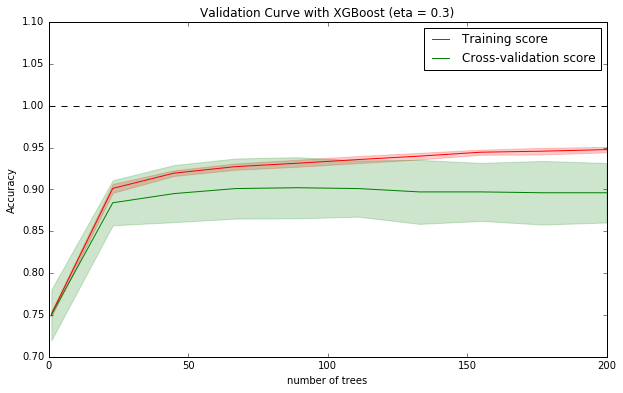

Best cross-validation result (0.90) obtained for 89 trees


In [11]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))

Looking at the plot we can draw the following conclusions:

- training score keeps growing while adding new trees, but from cerain point CV score is fixed
- variance is lowest, and bias is high for less than 25 trees,
- from about 25 trees, the variance is getting higher and while the CV score bias is holding steady (there is no point for adding extra trees / complexity)
- we can see that the model is quite stable keeping variance fixed when increasing it's complexity

We can assume that the trade-off for our model will be met at `n_estimators = 50`. The variance is still to big.

### What we can do?

#### Dealing with high variance
If model is too complex try:
- using less features (ie. feature selection),
- using more training samples (ie. artificially generated),
- increasing regularization (add penalties for extra complexity)

In XGBoost you can try to:
- reduce depth of each tree (`max_depth`),
- increase `min_child_weight` parameter,
- increase `gamma` parameter,
- add more randomness using `subsample`, `colsample_bytree` parameters,
- increase `lambda` and `alpha` regularization parameters

#### Dealing with high bias
If model is too simple:
- add more features (ie. better feature engineering),
- more sophisticated model
- decrease regularization

In XGBoost you can do it by:
- increase depth of each tree (`max_depth`),
- decrease `min_child_weight` parameter,
- decrease `gamma` parameter,
- decrease `lambda` and `alpha` regularization parameters

Let's try to tweak a parameters a little bit. We are going to add some randomness - each tree we will use 70% randomly chosen samples and 60% randomly chosen features. This should help to reduce a variance. To decrease the bias (bigger accuracy) try adding an extra level to each tree.

In [103]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth': 2, # changed
    'learning_rate': 0.3,
    'silent': 1.0,
    'colsample_bytree': 0.6, # added
    'subsample': 0.7 # added
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv,
    scoring='accuracy'
)

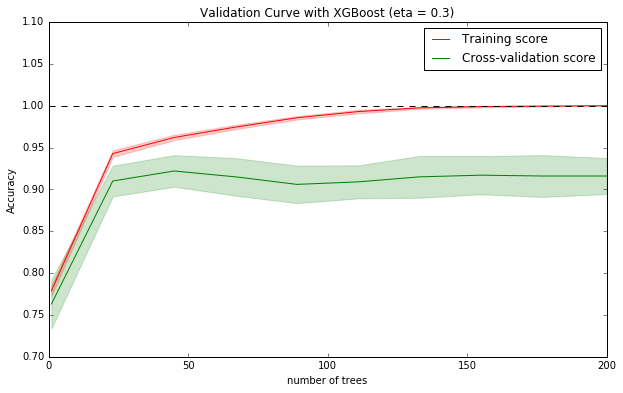

Best cross-validation result (0.92) obtained for 45 trees


In [104]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))

We have obtained slightly less variance and decreased bias.